# Data Lab 5
Some comments on Data Lab 4. Predictions using linear regression.

In [1]:
import numpy as np
import xarray as xr
#xr.set_options(keep_attrs = True)

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from datetime import datetime
months =[datetime(2019, imon, 1) for imon in np.arange(1,12+1)]
month_str = [date_obj.strftime('%b') for date_obj in months]
m_str = [w[0] for w in month_str];

# Get color order
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

### Data Lab 4 comments

5. (30 points) Look at the Oceanic Nino Index (ONI) values here https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php
    - Which winters since 2010 had cool ONI conditions?
    - Find the NOAA winter precipitation outlooks for those years and include them below. Here is the one for the winter of 2017-2018
      <div>
      <img src="https://www.climate.gov/sites/default/files/PrecipitationOutlook_Winter2017_620.png" width="400"/>
      </div>
    - Use the code below to read the Aug Nino 3.4 values from 1979 through 2020.
        - Find the 10 years with Aug Nino 3.4 values closest to that of 2020.
    - Use the code below to read the Dec-Feb (DJF) North America precipitation data for Dec 1979 - Feb 1980 though Dec 2019 - Feb 2020 (last winter). (The time coordinate of the precipitaion is the middle month (Jan) of the 3-month period.)
     - Use KNN with $K=10$ to
         - forecast the DJF precipitation (single map) 
         - Compute an 80% prediction interval (2 maps)
         - Compute the probability of the DJF precipitation being in the below, middle, and above terciles (3 maps)
ADD ANOMALIES

In [2]:
# Aug Nino 3.4 
n34_Aug_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.n34_Aug/dods'
n34_Aug_ds = xr.open_dataset(n34_Aug_url)
n34_Aug = n34_Aug_ds.n34_Aug - n34_Aug_ds.n34_Aug.mean('T')

In [3]:
prcp_DJF_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.prcp_DJF_NA/124/pop/dods'
prcp_DJF_ds = xr.open_dataset(prcp_DJF_url)
prcp = prcp_DJF_ds.prcp_DJF_NA
prcp = prcp
prcp.load();

`xarray` understands `pandas` datetime syntax

In [4]:
# Find the neighbors
knn = np.argsort( (n34_Aug[:-1] - n34_Aug[-1])**2 ).values[:10]
prcp_DJF_ds.T[knn].dt.year


<xarray.DataArray 'year' (T: 10)>
array([1986, 2017, 1982, 1990, 2001, 1996, 2012, 2014, 2008, 1981])
Coordinates:
  * T        (T) datetime64[ns] 1986-01-14T12:00:00 ... 1981-01-14T12:00:00

In [5]:
n34_Aug_ds.T[knn].dt.strftime('%m/%Y').values

array(['08/1985', '08/2016', '08/1981', '08/1989', '08/2000', '08/1995',
       '08/2011', '08/2013', '08/2007', '08/1980'], dtype=object)

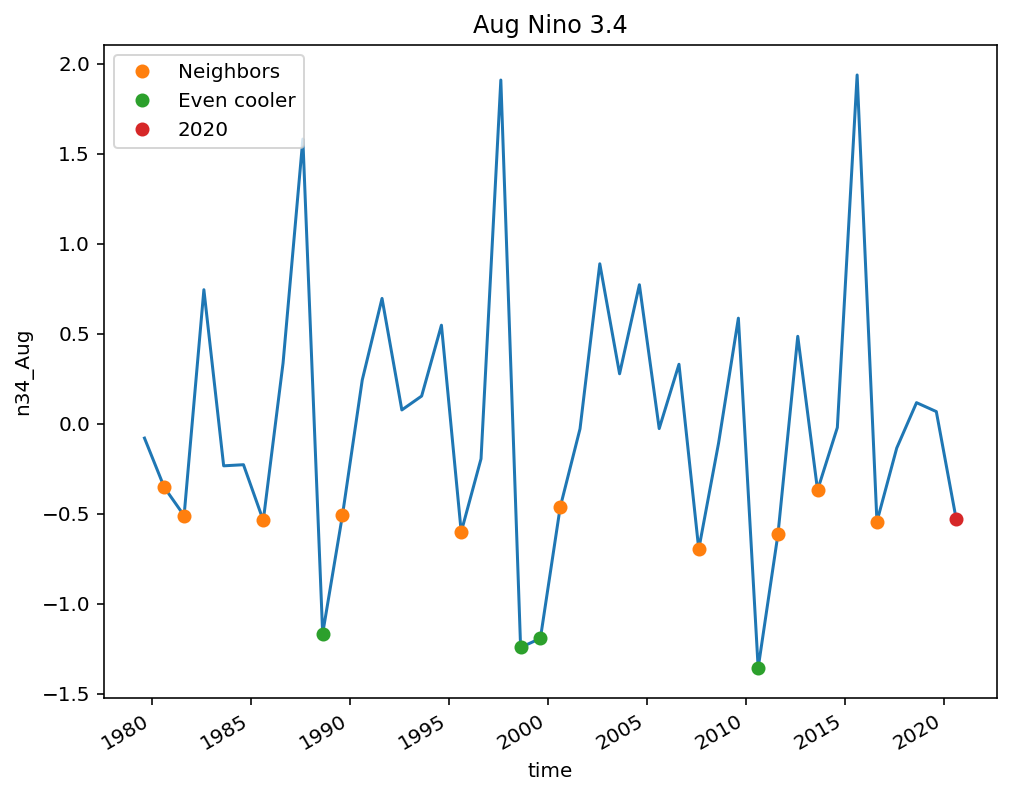

In [6]:
# Check that we have the right years
n34_Aug.plot(figsize = (8, 6));
n34_Aug[knn].plot.line('o', label = 'Neighbors')
n34_Aug.where(n34_Aug < -1).plot.line('o', label = 'Even cooler')
plt.plot(n34_Aug_ds.T[-1], n34_Aug[-1], 'o', label = '2020')
plt.title('Aug Nino 3.4')
plt.legend(loc = 'upper left');

Climatology is an average ...
Which average? Which years? Starting when? 1970? 1900?
Different mean -> different anomaly Part of the units!
Part of the answer is saying what climatology period was used. 

WMO recent 30-year period 1981 - 2010

In [7]:
# switch to anomalies
prcp = prcp - prcp.mean('T')

/Users/tippett/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [8]:
knn
prcp_DJF_ds.T[knn]

<xarray.DataArray 'T' (T: 10)>
array(['1986-01-14T12:00:00.000000000', '2017-01-14T12:00:00.000000000',
       '1982-01-14T12:00:00.000000000', '1990-01-14T12:00:00.000000000',
       '2001-01-14T12:00:00.000000000', '1996-01-15T00:00:00.000000000',
       '2012-01-15T00:00:00.000000000', '2014-01-14T12:00:00.000000000',
       '2008-01-15T00:00:00.000000000', '1981-01-14T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * T        (T) datetime64[ns] 1986-01-14T12:00:00 ... 1981-01-14T12:00:00
Attributes:
    gridtype:  0

In [9]:
# Many options for selecting the years
# Look before you leap
prcp.shape

(41, 62, 152)

In [10]:
forecast = prcp.isel(T=knn).mean('T')
forecast2 = prcp.sel(T = prcp_DJF_ds.T[knn]).mean('T')
forecast3 = prcp[knn, :, :].mean('T')
forecast4 = prcp[knn].mean('T')
((forecast - forecast2)**2).mean().values, ((forecast - forecast3)**2).mean().values, ((forecast - forecast4)**2).mean().values, 

(array(0., dtype=float32), array(0., dtype=float32), array(0., dtype=float32))

Text(0.5, 1.0, 'DJF 2020 (KNN)')

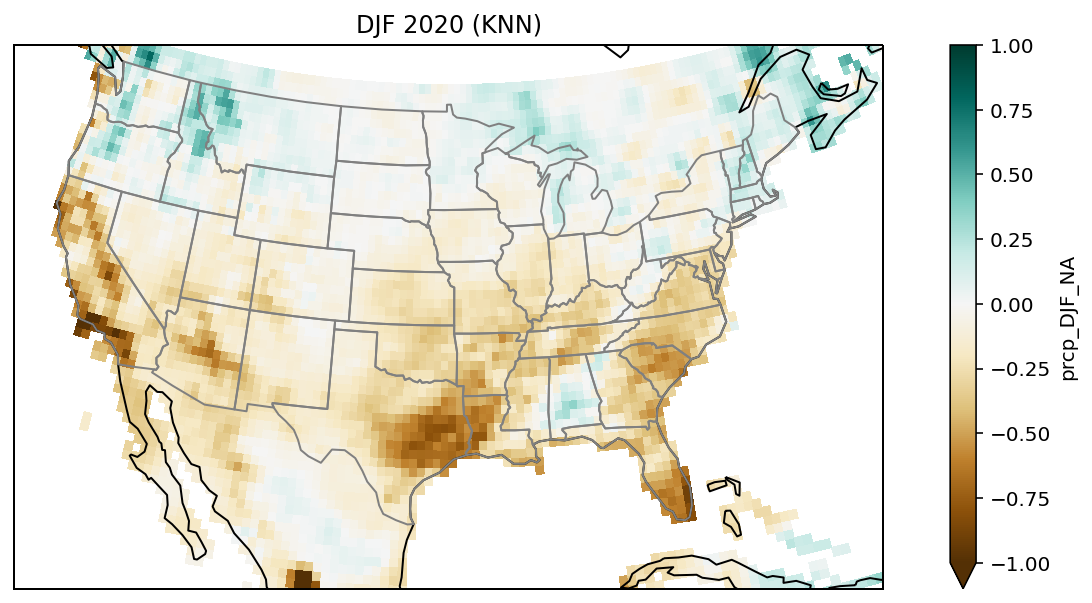

In [11]:
proj_map = ccrs.LambertConformal(central_longitude=-95, central_latitude=45)
proj_dta = ccrs.PlateCarree()  # the data's projection

fig = plt.figure(figsize=(12,5))
ax = plt.subplot(projection=proj_map)

extent = [-120, -70, 20, 50.5]

forecast.plot.pcolormesh(transform=proj_dta, ax = ax, vmin=-1, vmax=1, cmap='BrBG')
ax.coastlines();
ax.add_feature(cfeature.STATES, edgecolor='gray')
ax.set_extent(extent)
ax.set_title('DJF 2020 (KNN)')

In [12]:
prediction_interval = prcp.isel(T=knn).quantile([0.25,0.75], 'T')
prediction_interval

/Users/tippett/miniconda3/envs/pangeo/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


<xarray.DataArray 'prcp_DJF_NA' (quantile: 2, Y: 62, X: 152)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ..., -0.14428198,
         -0.24229014, -0.35710919],
        [        nan,         nan,         nan, ..., -0.77995917,
         -0.32153022, -0.37255931],
        [        nan,         nan,         nan, ..., -0.72208536,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,  0.75255841,
          0.42664337,  0.2697683 ],
        [        nan,         nan,         nan, ...,  0.68457896,
          0.35037255,  0.61252928],
        [        nan,         nan,         nan, ...,  0.41773236,
                 nan,         nan]]])
Coordinates:
  * X         (X) float32 -130.25 -129.75 -129.25 ... -55.75 -55.25 -54.75
  * Y         (Y) float32 19.75 20.25 20.75 21.25 ... 48.75 49.25 49.75 50.25
  * quantile  (quantile) float64 0.25 0.75

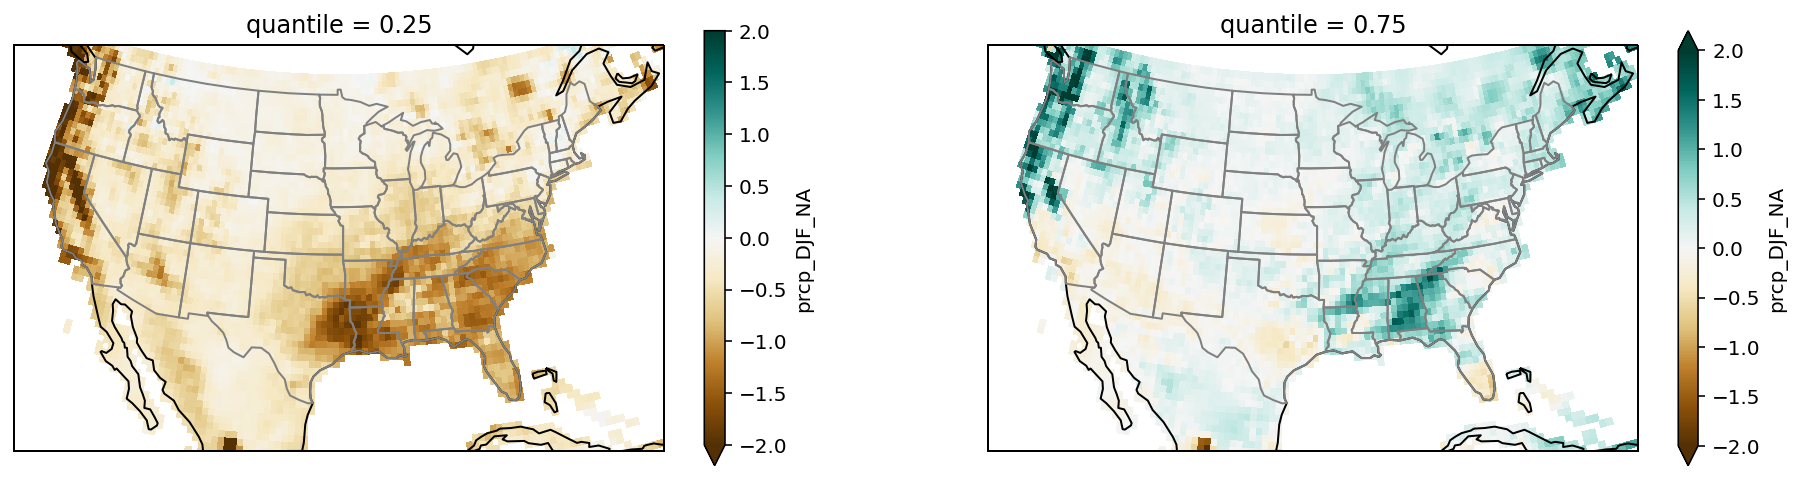

In [13]:
fig = plt.figure(figsize=(16,4))

extent = [-120, -70, 20, 50.5]

ax = plt.subplot(1, 2, 1, projection=proj_map)
prediction_interval.sel(quantile=0.25).plot.pcolormesh(transform=proj_dta, ax = ax, vmin=-2, vmax=2, cmap='BrBG')
ax.coastlines();
ax.add_feature(cfeature.STATES, edgecolor='gray')
ax.set_extent(extent)
#ax.set_title('10%-tile DJF 2020 (KNN)');

ax = plt.subplot(1, 2, 2, projection=proj_map)
prediction_interval.sel(quantile=0.75).plot.pcolormesh(transform=proj_dta, ax = ax, vmin=-2, vmax=2, cmap='BrBG')
ax.coastlines();
ax.add_feature(cfeature.STATES, edgecolor='gray')
ax.set_extent(extent)
#ax.set_title('90%-tile DJF 2020 (KNN)');

Looping over grid points is not a good idea. Why?

In [14]:
%%time
# No loops

ocean_nan = prcp.isel(T=0)*0

Below = (prcp.isel(T=knn) < prcp.quantile(1./3., dim = 'T')).mean('T') + ocean_nan
Above = (prcp.isel(T=knn) > prcp.quantile(2./3., dim = 'T')).mean('T') + ocean_nan
Middle = 1 - Below - Above
Above.name = 'Above'
Below.name = 'Below'

CPU times: user 831 ms, sys: 10.5 ms, total: 841 ms
Wall time: 839 ms


In [15]:
%%time
# Just the thresholds
prcp_knn = prcp.isel(T=knn)
threshold_B = prcp.quantile(1./3., dim = 'T')
threshold_A = prcp.quantile(2./3., dim = 'T')
threshold_A

/Users/tippett/miniconda3/envs/pangeo/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


CPU times: user 847 ms, sys: 22.3 ms, total: 869 ms
Wall time: 867 ms


<xarray.DataArray 'prcp_DJF_NA' (Y: 62, X: 152)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ..., 0.46349772, 0.28173081,
        0.27937261],
       [       nan,        nan,        nan, ..., 0.68508259, 0.35981894,
        0.46783861],
       [       nan,        nan,        nan, ..., 0.52965641,        nan,
               nan]])
Coordinates:
  * X         (X) float32 -130.25 -129.75 -129.25 ... -55.75 -55.25 -54.75
  * Y         (Y) float32 19.75 20.25 20.75 21.25 ... 48.75 49.25 49.75 50.25
    quantile  float64 0.6667

In [16]:
%%time
# Just the means
Below  = (prcp_knn < threshold_B).mean('T') + ocean_nan
Above  = (prcp_knn > threshold_A).mean('T') + ocean_nan

CPU times: user 5.17 ms, sys: 1.36 ms, total: 6.52 ms
Wall time: 4.89 ms


In [17]:
%%time
# Just the means with loops
for j in range(len(prcp.Y)):
    for k in range(len(prcp.X)):
        Below[j, k] = np.mean(prcp_knn[:, j, k] < threshold_B[j, k])
        Above[j, k] = np.mean(prcp_knn[:, j, k] > threshold_A[j, k])

CPU times: user 18.8 s, sys: 390 ms, total: 19.2 s
Wall time: 19.1 s


Donald Knuth famously quipped, "We should forget about small efficiencies, say about 97% of the time: premature optimization is the root of all evil."

There are 2 reasons to avoid loops here ...
1. Slow
2. Easier to read. Sometimes

In [18]:
19.8*1000/3.08

6428.571428571428

In [19]:
Below = Below + ocean_nan
Above = Above + ocean_nan

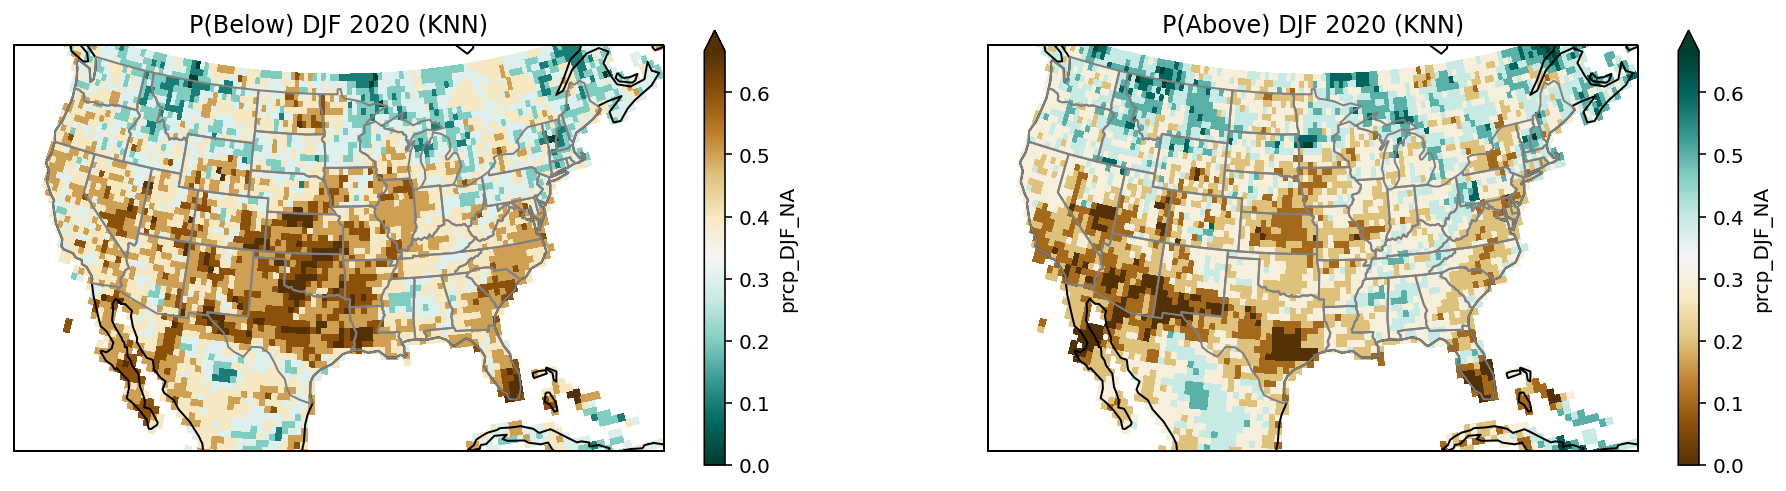

In [20]:
fig = plt.figure(figsize=(16,4))
extent = [-120, -70, 20, 50.5]

ax = plt.subplot(1, 2, 1, projection=proj_map)
Below.plot.pcolormesh(transform=proj_dta, ax = ax, vmin=0, vmax=2/3, cmap='BrBG_r')
ax.coastlines();
ax.add_feature(cfeature.STATES, edgecolor='gray')
ax.set_extent(extent)
ax.set_title('P(Below) DJF 2020 (KNN)');

ax = plt.subplot(1, 2, 2, projection=proj_map)
Above.plot.pcolormesh(transform=proj_dta, ax = ax, vmin=0, vmax=2/3, cmap='BrBG')
ax.coastlines();
ax.add_feature(cfeature.STATES, edgecolor='gray')
ax.set_extent(extent)
ax.set_title('P(Above) DJF 2020 (KNN)');

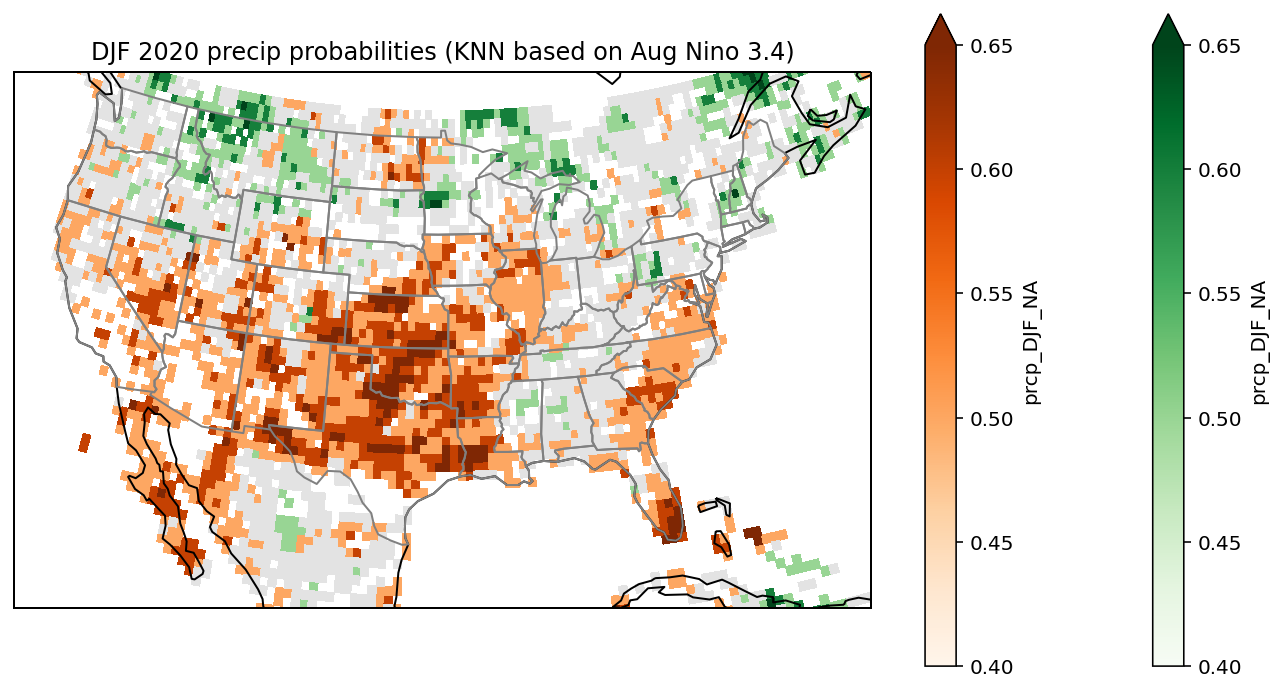

In [21]:
# Work in progress!
fig = plt.figure(figsize=(12,6))
ax = plt.subplot(projection=proj_map)

Above.where(Above > 0.4).plot(cmap = 'Greens', vmin = 0.4, vmax = 0.65, transform=proj_dta, ax = ax)
Below.where(Below > 0.4).plot(cmap = 'Oranges', vmin = 0.4, vmax = 0.65, transform=proj_dta, ax= ax)
ocean_nan.where( (np.abs(Above - 1/3) < 0.07) & (np.abs(Below - 1/3) < 0.07)).plot(vmin = -2, vmax = 0.25, cmap = 'gray',
                                                                                   transform=proj_dta, ax= ax, add_colorbar=False)
extent = [-120, -70, 20, 50.5]

ax.coastlines();
ax.add_feature(cfeature.STATES, edgecolor='gray')
ax.set_extent(extent)
ax.set_title('DJF 2020 (KNN)')

plt.title('DJF 2020 precip probabilities (KNN based on Aug Nino 3.4)');

2. (10 points) Suppose that $\hat{\mu}_{Y|x}$ is the average of $N$ independent samples from $p(y|x)$.  
Show that $E[ Y - \hat{\mu}_{Y|x} | X = x] = 0$ and that
$$ E[ (Y - \hat{\mu}_{Y|x})^2 | X = x] = \sigma_{Y|x}^2 \left(1 + \frac{1}{N} \right) \,.$$  

HINT What is the variance of the sample mean?
Forecast error is due to randomness and error in the estimate of the conditional mean.

![](images/sample_mean.pdf)  

This is a typical result
1. Uncertainty because $y|x$ is random.
2. Uncertainty because parameters are estimated from data.
3. Uncertainty because statistical models are an approximation. Hard to deal with.

## Linear regression forecast

For joint normally distributed $(x, y)$,

$$  y | x  \sim N( \mu_{y|x}, \sigma^2_{y|x} ) $$
<div>
<img src="images/climo_forecast_pdf.png" width="700"/>
</div>

The rough picture:
1. Find the least-squares estimate $\hat{\beta}$ that minimizes $\| y- X\beta \|^2$.
2. Compute the estimate $\hat{y}  = X \hat{\beta}$ of the conditional mean $\mu_{y|x}$.
3. Compute an estimate $\hat{\sigma}^2_{y|x}$ of the conditional variance $\sigma^2_{y|x}$.

Now we have estimates of the parameters that appear in the condictional  (forecast) distribution.

Q: How to combine all that into a forecast that reflects the uncertainty?

### Parameter estimates and their distributions

Given an $N \times 1$ vector of observations $y$, and an $N \times (p+1)$ matrix $X$ of predictors ($p$ changing predictors + intercept), the least-squares estimate of $\beta$ in $y = X\beta + \epsilon$ is

$$ \hat{\beta} = (X^TX)^{-1} X^T y $$

Two facts from the 11/6/2020 lecture on linear regression are needed to compute prediction intervals and tercile probabilities.

1. The sample estimate $\hat{\beta}$ is a multivariate random normal variable with mean $\beta$ (unbiased) and covariance  

$$ \text{cov } \left[ \hat{\beta} \right] = \sigma^2_{Y|x} (X^TX)^{-1} $$

2. For $R = y - \hat{y}$, 

$$ \frac{R^T R}{\sigma^2_{Y|x}} \sim \chi^2 (N - p - 1)$$
which means that 
$$ \hat{\sigma}^2_{Y|x} = \frac{1}{N - p -1} \sum_{i=1}^N (y_i - \hat{y}_i)^2 $$
is an unbiased estimate.

### Step 1. Forecast error mean and variance

Now suppose we have a new data point $X_0$ (one row) and make a forecast based on it
$$ \hat{y}_0 = X_0 \hat{\beta} $$
of the corresponding $y_0$
$$ y_0 = X_0 \beta + \epsilon_0 $$

The quantity $y_0 - \hat{y}_0$ (forecast erorr) is normally distributed because it is a linear combinateion of normally distributed random variables:

$$y_0 - \hat{y}_0 = X_0 (\beta - \hat{\beta}) + \epsilon_0 $$

$E[y_0 - \hat{y}_0] = 0$ because $E[\beta - \hat{\beta}] = 0$ and $E[\epsilon_0] = 0$.

It remains to compute the variance:
$$\text{var } \left[ y_0 - \hat{y}_0 \right]  = \text{var } \left[ X_0 (\beta - \hat{\beta}) \right] + \sigma^2_{Y|x}$$
(there is no cross-term because $\epsilon_0$ is independent of $\hat{\beta}$.

$$ \text{var } \left[ X_0 (\beta - \hat{\beta}) \right] = E \left[ (X_0 (\beta - \hat{\beta}))^2 \right] 
= E\left[ X_0^T (\beta - \hat{\beta})(\beta - \hat{\beta})^T X_0 \right] = X_0^T \text{cov } \left[ \hat{\beta} \right] X_0 = \sigma^2_{Y|x} X_0^T (X^TX)^{-1} X_0$$

Therefore,
$$\text{var } \left[ y_0 - \hat{y}_0 \right]  = \sigma^2_{Y|x} \left( 1 + X_0^T (X^TX)^{-1} X_0 \right)$$

Summary:
1. $E[y_0 - \hat{y}_0] = 0$
2. $\text{var } \left[ y_0 - \hat{y}_0 \right]  = \sigma^2_{Y|x} \left( 1 + X_0^T (X^TX)^{-1} X_0 \right)$

The conditional variance is the sum of two terms: 
1. Inherent uncertainty due to $X$ not explaining everything $\sigma^2_{Y|x}$
2. Uncertainty in the estimate of the regression coefficients  $\sigma^2_{Y|x}  X_0^T (X^TX)^{-1} X_0$

![](images/regression.pdf)

### Step 2 Putting together the "t"

$$ Z = \frac{y_0 - \hat{y}_0}{\sigma_{Y|x} \sqrt{1 + X_0^T (X^TX)^{-1} X_0 }} \sim N(0,1)$$

$$ V = \frac{R^T R}{\sigma^2_{Y|x}} \sim \chi^2 (N - p - 1)$$

Therefore,

$$ t = \frac{Z}{\sqrt{V/(N - p - 1)}} \sim T(N - p - 1)$$

$$ t = \frac{y_0 - \hat{y}_0}{\sigma_{Y|x} \sqrt{1 + X_0^T (X^TX)^{-1} X_0 }} \frac{\sigma_{Y|x}}{\hat{\sigma}_{Y|x}} 
= 
\frac{y_0 - \hat{y}_0}{\hat{\sigma}_{Y|x} \sqrt{1 + X_0^T (X^TX)^{-1} X_0 }}$$
And we are in business.

## 1. Indonesia example (JJA)

In [ ]:
# Read JJA Nino 3.4
n34_JJA_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.n34_JJA/dods'
n34_JJA_ds = xr.open_dataset(n34_JJA_url)
n34_JJA = n34_JJA_ds.n34_JJA

In [ ]:
# Read Indonesia region rainfall
indo_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.indonesia_prcp_JJA/dods'
indo_ds = xr.open_dataset(indo_url)
prcp_indo = indo_ds.indonesia_prcp_JJA

In [ ]:
# Train our prediction on all the values up to this year and then predict this year's value from xp
x = n34_JJA[0:-1].values
xm = x.mean()
xa = x - xm
x0 = n34_JJA[-1].values - xm
y = indo_ds.indonesia_prcp_JJA[:-1].values
y0 = indo_ds.indonesia_prcp_JJA[-1].values
N = len(n34_JJA)

### 1.1 Use linear regression to rainfall based on the value of JJA Nino 3.4.

$Y$ rainfall amount. $X$ = Nino 3.4

Forecast (conditional) distribution
$$ p( y | x )$$

Least-squares estimate of $\hat{\beta}$

$$ \hat{\beta} = (X^TX)^{-1}X^T y$$

$$ \hat{y} = X \hat{\beta} $$ 

In [ ]:
from numpy.linalg import inv

Nx = len(xa)
X = np.empty((Nx,2))
X[:,1] = xa
X[:,0] = 1
beta = inv(X.T@X)@X.T@y
yhat = X@beta

fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(xa, y, 'o', label = 'y');
ax.plot(xa, yhat, 'o', label = 'yhat');

ax.set_xlabel('Nino 3.4')
ax.set_ylabel('Rainfall');

x_line = np.linspace(-1.6, 1.6)
ax.plot(x_line, beta[1]*x_line + beta[0], color = 'k');

for ii in range(0, N - 1):
    ax.plot(xa[ii]*np.array([1,1]), np.array([yhat[ii], y[ii]]), color = colors[4])
ax.plot(xa[ii]*np.array([1,1]), np.array([yhat[ii], y[ii]]), color = colors[4], label = 'residuals')
ax.legend();

####  - Estimate of conditional mean (best single number)

$$ \hat{y}_0 = X_0 \hat{\beta} $$

In [ ]:
y0_hat = beta[1]*x0 + beta[0]
print('Forecast total = {:4.2f} mm/day'.format(y0_hat))
print('Forecast anomaly = {:4.2f} mm/day'.format(y0_hat - y.mean()))

#### - Residuals

In [ ]:
R = y - yhat

fig, ax = plt.subplots(figsize=(6, 5))

ax.plot(xa, R, 'o');
ax.set_xlabel('Nino 3.4')
ax.set_ylabel('Residuals = y - y_hat');

#### - Estimate variance

In [ ]:
sigma_hat = np.sqrt(R.T@R/(N - 2))
print(sigma_hat)
sigma_hat_LR = np.std(y - yhat, ddof=2)
print(sigma_hat)

####  - 80% prediction interval

In [ ]:
# Interval that we expect to contain the observation 8-% of the time
t_20 = stats.t.ppf(1 - 0.2/2, df = Nx - 1)
X0 = np.array([1, x0])
Xfactor = np.sqrt(1. + X0.T@inv(X.T@X)@X0)
pi_80_LR = y0_hat + np.array([-1, 1])*sigma_hat*t_20*Xfactor
print('80% of the time during La Nina, JJA rainfall totals have been in the range', pi_80_LR)
print('80% of the time during La Nina, JJA rainfall anomalies have been in the range', pi_80_LR - y.mean())

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(xa, y, 'o');
ax.set_xlabel('Nino 3.4')
ax.set_ylabel('Rainfall');

x_line = np.linspace(-1.6, 1.6)
ax.plot(x_line, beta[1]*x_line + beta[0], 'k', label = 'Regression line');
ax.plot(x0, y0_hat, 'o', label = '2020 LR prediction')
ax.plot(x0, y0, 'o', label = '2020 obs.')

# Interval that we expect to contain the observation 80% of the time
sigma_hat_LR = np.std(y - yhat, ddof=2)
t_20 = stats.t.ppf(1 - 0.2/2, df = Nx - 1)
Xp = np.array([x0, 1])
Xfactor = np.sqrt(1. + Xp.T@inv(X.T@X)@Xp)
pi_80_LR = y0_hat + np.array([-1, 1])*sigma_hat_LR*t_20*Xfactor

ax.plot(x0 + np.zeros_like(pi_80_LR), pi_80_LR, label='80% prediction interval')
ax.legend();

####  - Tercile probabilities

In [ ]:
y_thresholds = np.quantile(y, np.array([1., 2.])/3)

df = Nx - 2 
t_below = (y_thresholds[0] - y0_hat)/sigma_hat/Xfactor
t_above = (y_thresholds[1] - y0_hat)/sigma_hat/Xfactor

P_below = stats.t.cdf(t_below,df)
P_above = 1 - stats.t.cdf(t_above,df)
P_middle = 1 - P_above - P_below

fig, ax = plt.subplots(figsize = (9, 5))
ax.bar(np.arange(0,3), 100*np.array([P_below, 1 - P_above - P_below, P_above]))
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['Below', 'Middle', 'Above'])
ax.set_ylabel('Probability [%]')
ax.set_title('JJA Indonesia rainfall probabilities based on 2020 Nino 3.4');
ax.text(0, 5, '{:2.1f}'.format(P_below*100), horizontalalignment='center')
ax.text(1, 5, '{:2.1f}'.format(P_middle*100), horizontalalignment='center')
ax.text(2, 5, '{:2.1f}'.format(P_above*100), horizontalalignment='center')

Summary of how the different methods did for Indonesia rainfall
1. Categorical:
    - 6.29 mm/day
    - 80% prediction interval [5.70192914 6.77854986]
    - Tercile probabilities: (7.1, 21.4, 71.4)
2. KNN
    - 6.09 mm/day
    - 80% prediction interval [5.53616681, 6.42385831]
    - Tercile probabilities: (40, 40, 50)
3. Linear regression
    - 6.03 mm/day
    - 80% prediction interval [5.32491351 6.73996211]
    - Tercile probabilities: (16.5, 39.6, 43.8)
    
Actual: 5.9643126, middle category.

## Exercises

Use the following data sets:  
- Aug Nino 3.4
- Sep Nino 3.4
- DJF US near-surface (2-meter) temperature "t2m"

In [ ]:
# Aug Nino 3.4 
n34_Aug_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.n34_Aug/dods'
n34_Aug_ds = xr.open_dataset(n34_Aug_url)
n34_Aug = n34_Aug_ds.n34_Aug - n34_Aug_ds.n34_Aug.mean('T')
n34_Aug.plot();

In [ ]:
# Sep Nino 3.4
n34_Sep_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.n34_Sep/dods'
n34_Sep_ds = xr.open_dataset(n34_Sep_url)
n34_Sep = n34_Sep_ds.n34_Sep - n34_Sep_ds.n34_Sep.mean('T')
n34_Sep.plot();

In [ ]:
# 2-meter temperature
t2m_DJF_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.t2m_DJF/dods'
t2m_DJF_ds = xr.open_dataset(t2m_DJF_url)
t2m_DJF_ds.t2m_DJF.mean('T').plot();

#### 1. The big picture
Add code to make this plot
<div>
<img src="images/climo_forecast_pdf.png" width="700"/>
</div>

In [ ]:
x = np.linspace(-4 , 4, 200)

# Climatology
mu_y = 0.0
sigma_y = 1.
# forecast (conditional)
mu_f = 0.55
sigma_f = np.sqrt(1 - 0.5**2)

fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(x, stats.norm.pdf(x, loc = mu_y, scale = sigma_y), label = 'p(y) (Climatology)');
ax.plot(x, stats.norm.pdf(x, loc = mu_f, scale = sigma_f), label = 'p(y | x) (Forecast)');

#### 2 Exploring the data.  

- (5 points) Make a scatterplot of Aug and Sep values of Nino 3.4. Compute their correlation. Does `xr.corr` work? If not, explain. Indicate the 2020 point on the plot.
- (10 points) Compute the map average of the t2m data and plot the resulting values as a function of time. Compute the map average two ways:
    - Weight all points equally
    - Weight points propotional to their area. Recall that in spherical coordinates the surface element depends on lattitide
- (5 points) Plot a map of the Dec - Feb 2020 t2m anomalies 
    - with respect to the 1980 - 2010 climatology
    - with respect to the 1980 - 2020 climatology
    - Explain the difference.

#### 3. Forecasting
Use North American t2m anomalies with respect to the 1980-2010 period in your calculations.

- (5 points) Compute and plot the 33.3 and 66.7 percentiles of DJF t2m anomalies (2 maps). 

- (10 points) Make a linear regression forecast of the upcoming DJF t2m anomalies based on the 2020 value of Sep Nino 3.4. (Number of predictors (number of columns of $X$) = 1 + intercept).
    - Plot the forecast (conditional mean) anomalies (one map).
    - Plot your estimate of the forecast (conditional) std.
    - Plot the probabilities of the below, middle, and above categories on one map.
- (10 points) Make a linear regression forecast of the upcoming DJF t2m anomalies based on the 2020 value of Sep Nino 3.4 and the year (trend). (Number of predictors (number of columns of $X$) = 2 + intercept).
    - Plot the forecast (conditional mean) anomalies (one map).
    - Plot your estimate of the forecast (conditional) std.
    - Plot the probabilities of the below, middle, and above categories on one map.
- (10 points) Avoid looping over grid points.
- (5 points) Compare your forecasts to the [CPC](https://www.cpc.ncep.noaa.gov/products/predictions/long_range/seasonal.php?lead=2) and [IRI](https://iri.columbia.edu/our-expertise/climate/forecasts/seasonal-climate-forecasts/) ones.